In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
from cautious_extrapolation.utils import get_imagenet_features
from cautious_extrapolation.data_paths import DATA_PATHS
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from dataset import ImageNet200
from torchvision.datasets import ImageFolder
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import make_pipeline

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])


valdir = os.path.join(DATA_PATHS["nfs"]["ImageNet"], 'val')
val_dataset = ImageNet200(
    valdir,
    transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ]))

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=64, shuffle=True,
    num_workers=4, pin_memory=True)


imagenet_r_dataset = ImageFolder(DATA_PATHS["nfs"]["ImageNet-R"],
    transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ]))

imagenet_r_loader = torch.utils.data.DataLoader(
    imagenet_r_dataset,
    batch_size=64, shuffle=True,
    num_workers=4, pin_memory=True)


imagenet_s_dataset = ImageNet200(
    DATA_PATHS["nfs"]["ImageNet-S"],
    transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ]))

imagenet_s_loader = torch.utils.data.DataLoader(
    imagenet_s_dataset,
    batch_size=64, shuffle=True,
    num_workers=4, pin_memory=True)


In [3]:
val_features = get_imagenet_features(val_loader)
idxs = np.random.permutation(val_features.shape[0])
val_features = val_features[idxs]

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
imagenet_r_features = get_imagenet_features(imagenet_r_loader)
idxs = np.random.permutation(imagenet_r_features.shape[0])
imagenet_r_features = imagenet_r_features[idxs]

num_points = min(val_features.shape[0], imagenet_r_features.shape[0])
imagenet_r_features_train = imagenet_r_features[:int(0.9*num_points)]
val_features_train = val_features[:int(0.9*num_points)]


X = np.concatenate((val_features_train, imagenet_r_features_train), axis=0)
y = np.concatenate((np.ones(len(val_features_train)), np.zeros(len(imagenet_r_features_train))), axis=0)

scores = []
for _ in range(30):
    clf = make_pipeline(StandardScaler(), SGDClassifier(loss="log", max_iter=20, alpha=10))
    clf.fit(X, y)
    score = clf.predict_log_proba(imagenet_r_features[int(0.9*num_points):])[:, 0].mean()
    scores.append(score)
imagenet_r_score = np.mean(scores)


print(imagenet_r_score)

-0.5430929611135101


In [5]:
imagenet_s_features = get_imagenet_features(imagenet_s_loader)
idxs = np.random.permutation(imagenet_s_features.shape[0])
imagenet_s_features = imagenet_s_features[idxs]

num_points = min(val_features.shape[0], imagenet_s_features.shape[0])
imagenet_s_features_train = imagenet_s_features[:int(0.9*num_points)]
val_features_train = val_features[:int(0.9*num_points)]


X = np.concatenate((val_features_train, imagenet_s_features_train), axis=0)
y = np.concatenate((np.ones(len(val_features_train)), np.zeros(len(imagenet_s_features_train))), axis=0)

scores = []
for _ in range(30):
    clf = make_pipeline(StandardScaler(), SGDClassifier(loss="log", max_iter=20, alpha=10))
    clf.fit(X, y)
    score = clf.predict_log_proba(imagenet_s_features[int(0.9*num_points):])[:, 0].mean()
    scores.append(score)
imagenet_s_score = np.mean(scores)
print(imagenet_s_score)

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


-0.462808858496894


In [10]:
f_star = [-4*199/200+1*1/200 for _ in range(200)]
f_star.append(0)
f_star = np.array(f_star)

run_names = ["reward_prediction_seed0_2023_06_16_13_27_08",
             "reward_prediction_seed1_2023_06_21_09_58_58",
             "reward_prediction_seed2_2023_06_21_21_00_20",
             "reward_prediction_seed3_2023_06_22_07_56_32",
             "reward_prediction_seed4_2023_06_22_23_23_39"]

train_dist_from_f_starts_all = []
r_dist_from_f_starts_all = []
s_dist_from_f_starts_all = []
for run_name in run_names:
    file = "data/"+run_name+"/outputs.pkl"
    with open(file, "rb") as f:
        data = pickle.load(f)
        train_dist_from_f_starts_all.append(((data[0]- np.expand_dims(f_star, axis=0))**2).mean())
        r_dist_from_f_starts_all.append(((data[1]- np.expand_dims(f_star, axis=0))**2).mean())
        s_dist_from_f_starts_all.append(((data[2]- np.expand_dims(f_star, axis=0))**2).mean())

In [11]:
train_dist_from_f_starts_all = np.array(train_dist_from_f_starts_all)
r_dist_from_f_starts_all = np.array(r_dist_from_f_starts_all)
s_dist_from_f_starts_all = np.array(s_dist_from_f_starts_all)

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  


(0.48, 0.67)

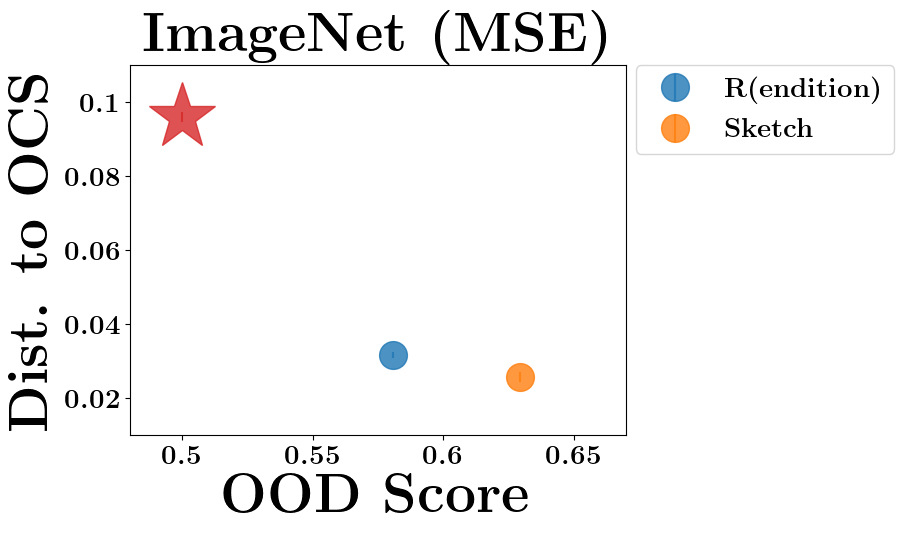

In [12]:


import matplotlib as mpl
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']

colors=["C3", "C0", "C1", "C2", "C4", "C5", "C6", "C7", "C8", "C9"]

# plt.rcParams["figure.figsize"] = [2*5.3, 2*4.8]
plt.figure()
ax = plt.gca()


plt.errorbar([0.5], [train_dist_from_f_starts_all.mean(axis=0)], yerr=[train_dist_from_f_starts_all.std(axis=0)], fmt='*', markersize=50, zorder=100, alpha=0.8, color=colors[0])


plt.errorbar(np.e**imagenet_r_score, r_dist_from_f_starts_all.mean(axis=0), yerr=r_dist_from_f_starts_all.std(axis=0), fmt="o", markersize=20, label=r"\textbf{R(endition)}", alpha=0.8, color=colors[1])
plt.errorbar(np.e**imagenet_s_score, s_dist_from_f_starts_all.mean(axis=0), yerr=s_dist_from_f_starts_all.std(axis=0), fmt="o", markersize=20, label=r"\textbf{Sketch}", alpha=0.8, color=colors[2])


plt.xlabel(r"\textbf{OOD Score}", fontsize=40)
plt.ylabel(r"\textbf{Dist. to OCS}", fontsize=40)
plt.title(r"\textbf{ImageNet (MSE)}", fontsize=40)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=20)
plt.yticks([0.02+_*0.02 for _ in range(5)], [r"\textbf{"+str(0.02+_*0.02)+"}" for _ in range(5)], fontsize=20)
plt.xticks([0.5+0.05*_ for _ in range(5)], [r"\textbf{"+str(0.5+0.05*_)+"}" for _ in range(5)], fontsize=20)
plt.ylim([0.01, 0.11])
plt.xlim([0.48, 0.67])

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.


(0.48, 0.67)

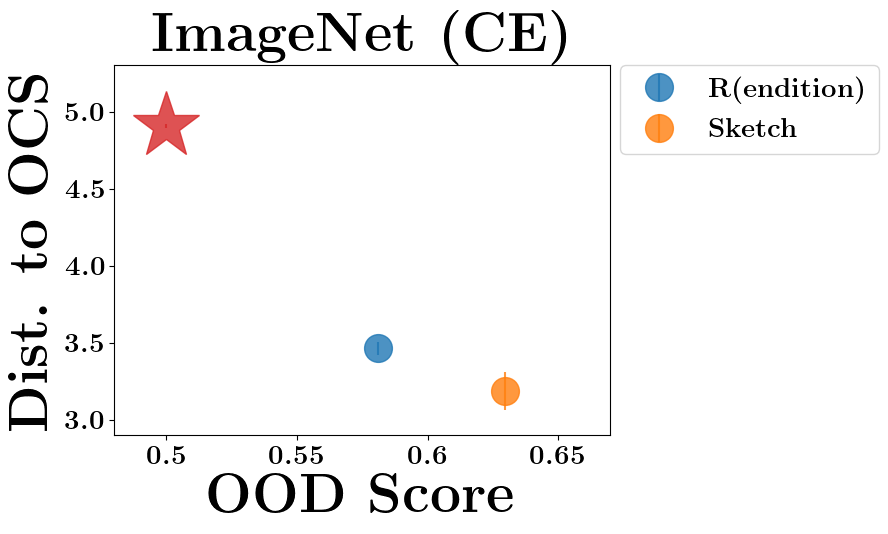

: 

In [19]:
from scipy.special import softmax

f_star = [-4*199/200+1*1/200 for _ in range(200)]
f_star.append(0)
f_star = np.array(f_star)

run_names = ["xent_seed0_2023_06_21_04_29_07",
             "xent_seed1_2023_06_21_15_30_38",
             "xent_seed2_2023_06_22_02_28_39",
             "xent_seed3_2023_06_22_17_49_30",
             "xent_seed4_2023_06_23_04_54_45"]
class_probs = np.array([1/200 for _ in range(200)])
train_dist_from_f_starts_all = []
r_dist_from_f_starts_all = []
s_dist_from_f_starts_all = []
for run_name in run_names:
    file = "data/"+run_name+"/outputs.pkl"
    with open(file, "rb") as f:
        data = pickle.load(f)
        dist  = softmax(data[0], axis=-1)
        train_dist_from_f_starts_all.append(np.sum(dist*np.log(dist/np.expand_dims(class_probs, axis=0)), axis=-1).mean())
        dist  = softmax(data[1], axis=-1)
        r_dist_from_f_starts_all.append(np.sum(dist*np.log(dist/np.expand_dims(class_probs, axis=0)), axis=-1).mean())
        dist  = softmax(data[2], axis=-1)
        s_dist_from_f_starts_all.append(np.sum(dist*np.log(dist/np.expand_dims(class_probs, axis=0)), axis=-1).mean())

train_dist_from_f_starts_all = np.array(train_dist_from_f_starts_all)
r_dist_from_f_starts_all = np.array(r_dist_from_f_starts_all)
s_dist_from_f_starts_all = np.array(s_dist_from_f_starts_all)



import matplotlib as mpl
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']

colors=["C3", "C0", "C1", "C2", "C4", "C5", "C6", "C7", "C8", "C9"]

# plt.rcParams["figure.figsize"] = [2*5.3, 2*4.8]
plt.figure()
ax = plt.gca()


plt.errorbar([0.5], [train_dist_from_f_starts_all.mean(axis=0)], yerr=[train_dist_from_f_starts_all.std(axis=0)], fmt='*', markersize=50, zorder=100, alpha=0.8, color=colors[0])


plt.errorbar(np.e**imagenet_r_score, r_dist_from_f_starts_all.mean(axis=0), yerr=r_dist_from_f_starts_all.std(axis=0), fmt="o", markersize=20, label=r"\textbf{R(endition)}", alpha=0.8, color=colors[1])
plt.errorbar(np.e**imagenet_s_score, s_dist_from_f_starts_all.mean(axis=0), yerr=s_dist_from_f_starts_all.std(axis=0), fmt="o", markersize=20, label=r"\textbf{Sketch}", alpha=0.8, color=colors[2])


plt.xlabel(r"\textbf{OOD Score}", fontsize=40)
plt.ylabel(r"\textbf{Dist. to OCS}", fontsize=40)
plt.title(r"\textbf{ImageNet (CE)}", fontsize=40)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=20)
plt.yticks([3+_*0.5 for _ in range(5)], [r"\textbf{"+str(3+_*0.5)+"}" for _ in range(5)], fontsize=20)
plt.xticks([0.5+0.05*_ for _ in range(5)], [r"\textbf{"+str(0.5+0.05*_)+"}" for _ in range(5)], fontsize=20)
plt.ylim([2.9, 5.3])
plt.xlim([0.48, 0.67])